# 01 Data Preparation

**Assignment 1: Data Foundation**

- Load raw review.json (JSONL) into SQLite
- Filter to **latest 5 years** (assignment requirement)
- Ensure **50,000–80,000+ reviews** after filtering
- Create **reviews_sample.db** with 5,000+ reviews for TAs
- Document schema and indexing

In [2]:
# Setup: find project root (dir containing "src") and add to path
import sys
from pathlib import Path
project_root = Path.cwd().resolve()
while project_root != project_root.parent and not (project_root / "src").exists():
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from src.utils import get_engine, get_db_path
import pandas as pd

## 1. Full load (run once)

Full ETL streams review.json line-by-line into data/reviews.db. Run from project root:
```bash
python -m src.data_processing --full-etl
```
Optional: run the cell below to run ETL from the notebook (requires review.json in data/).

In [3]:
# Connect to full DB (or sample if full not present)
sample_path = get_db_path(sample=True)
full_path = get_db_path(sample=False)
use_sample = not full_path.exists()
engine = get_engine(sample=use_sample)
print(f"Using: {'sample' if use_sample else 'full'} DB")

Using: full DB


In [4]:
# Data volume and schema check
n_reviews = pd.read_sql("SELECT COUNT(*) AS n FROM reviews", engine).iloc[0]["n"]
n_authors = pd.read_sql("SELECT COUNT(*) AS n FROM authors", engine).iloc[0]["n"]
n_hotels = pd.read_sql("SELECT COUNT(DISTINCT offering_id) AS n FROM reviews", engine).iloc[0]["n"]
print(f"Reviews: {n_reviews:,} | Authors: {n_authors:,} | Hotels: {n_hotels:,}")
pd.read_sql("SELECT * FROM reviews LIMIT 2", engine)

# Summary: top 10 hotels by review count (for report)
pd.read_sql("""SELECT offering_id, COUNT(*) AS n_reviews, ROUND(AVG(rating_overall), 2) AS avg_rating FROM reviews GROUP BY offering_id ORDER BY n_reviews DESC LIMIT 10""", engine)

Reviews: 878,561 | Authors: 576,688 | Hotels: 3,945


,offering_id,n_reviews,avg_rating
0,214197,5456,2.47
1,93520,4009,3.50
2,122005,3726,4.01
3,93618,3534,3.90
4,223023,3385,3.17
5,99766,3218,3.55
6,93562,3170,4.13
7,93437,3034,3.52
8,611947,3004,3.76
9,208454,2898,4.57


## 2. Latest 5 years filter

Assignment: use **latest 5 years** available. Date format: e.g. "December 17, 2012". Extract year and filter in analysis.

Year range: 2001 - 2007


<Axes: title={'center': 'Reviews by year (sample)'}, xlabel='year'>

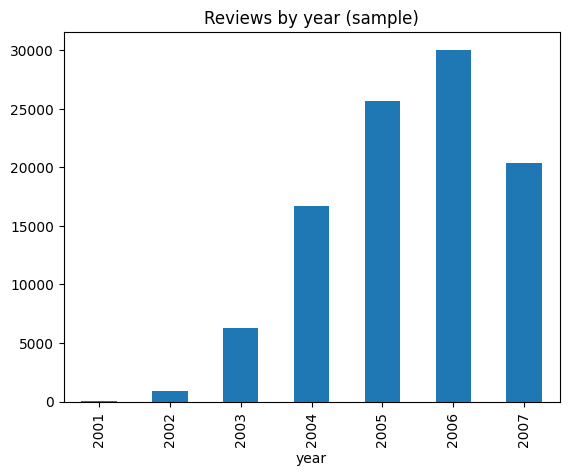

In [5]:
# Year distribution (sample)
df = pd.read_sql("SELECT date FROM reviews WHERE date IS NOT NULL LIMIT 100000", engine)
from dateutil import parser
def safe_year(s):
    try: return parser.parse(str(s).strip()).year
    except: return None
df["year"] = df["date"].apply(safe_year)
df = df.dropna(subset=["year"])
print("Year range:", df["year"].min(), "-", df["year"].max())
df["year"].value_counts().sort_index().plot(kind="bar", title="Reviews by year (sample)")

## 3. Create sample DB (5,000+ reviews for TAs)

Run from project root: `python -m src.data_processing`

In [6]:
from src.data_processing import build_sample_db
try:
    path = build_sample_db(sample_size=5000)
    print(f"Created {path}")
except FileNotFoundError as e:
    print("Run: python -m src.data_processing --full-etl first.", e)

Created /home/simon/IS5126/IS5126-G4-hotel-analytics/data/reviews_sample.db
